# Goal of this project:
### Craete Logistic Regression for Sentiment analysis from scratch

## Get the initial Data

In [7]:
# run this cell to import nltk
import nltk
from os import getcwd

# add folder, tmp2, from our local workspace containing pre-downloaded corpora files to nltk's data path
# this enables importing of these files without downloading it again when we refresh our workspace

filePath = f"{getcwd()}/../tmp2/"
nltk.data.path.append(filePath)


import numpy as np
import pandas as pd
from nltk.corpus import twitter_samples 

from utils import process_tweet, build_freqs,sigmoid

import matplotlib.pyplot as plt

## Train Test split

In [8]:
# select the set of positive and negative tweets
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg

# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)


# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

print(len(train_x))
print(train_x[20])

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)
8000
#FollowFriday @MBandScott_ @Eric_FLE @pointsolutions3 for being top new followers in my community this week :)


# Find the Frequency that every word appear in the positive and negative sentiment 

In [9]:
# create frequency dictionary
freqs = build_freqs(train_x, train_y)

# check the output
print("type(freqs) = " + str(type(freqs)))
print("len(freqs) = " + str(len(freqs.keys())))


type(freqs) = <class 'dict'>
len(freqs) = 11346


## Table of word counts - Visualize Results 

In [10]:
# select some words to appear in the report. we will assume that each word is unique (i.e. no duplicates)
keys = ['happi', 'merri', 'nice', 'good', 'bad', 'sad', 'mad', 'best', 'pretti',
        '❤', ':)', ':(', '😒', '😬', '😄', '😍', '♛',
        'song', 'idea', 'power', 'play', 'magnific']

# list representing our table of word counts.
# each element consist of a sublist with this pattern: [<word>, <positive_count>, <negative_count>]
data = []

# loop through our selected words
for word in keys:
    
    # initialize positive and negative counts
    pos = 0
    neg = 0
    
    # retrieve number of positive counts
    if (word, 1) in freqs:
        pos = freqs[(word, 1)]
        
    # retrieve number of negative counts
    if (word, 0) in freqs:
        neg = freqs[(word, 0)]
        
    # append the word counts to the table
    data.append([word, pos, neg])
    
data

[['happi', 161, 18],
 ['merri', 1, 0],
 ['nice', 70, 17],
 ['good', 191, 83],
 ['bad', 14, 54],
 ['sad', 5, 100],
 ['mad', 3, 8],
 ['best', 49, 16],
 ['pretti', 17, 12],
 ['❤', 21, 15],
 [':)', 2847, 2],
 [':(', 1, 3663],
 ['😒', 1, 3],
 ['😬', 0, 2],
 ['😄', 3, 1],
 ['😍', 1, 0],
 ['♛', 0, 210],
 ['song', 16, 25],
 ['idea', 23, 8],
 ['power', 6, 5],
 ['play', 37, 39],
 ['magnific', 1, 0]]

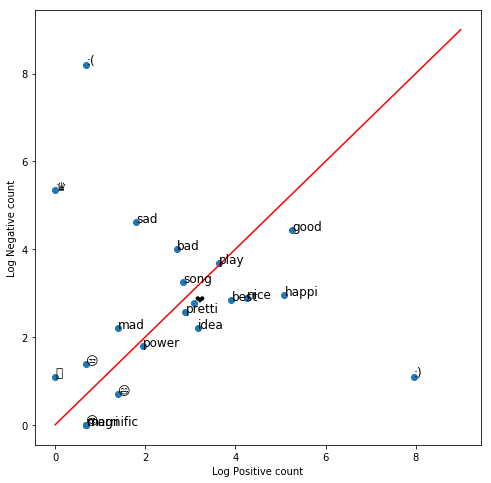

In [11]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])  

# do the same for the negative counts
y = np.log([x[2] + 1 for x in data]) 

# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()

## Gradient Descent from scratch

In [12]:

def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    
    m = x.shape[0]
    print(m)
    
    for i in range(0, num_iters):
        z = np.dot(x,theta)
        h = sigmoid(z)
        
        J = -(1/m)*(   np.dot(y.transpose(),np.log(h))   +   np.dot(1-y.transpose(),np.log(1-h))  )
        gradJ =  (1/m)*np.dot(x.transpose(),h-y)
        theta = theta - alpha*gradJ
        
        
    J = float(J)
    return J, theta

## Extract Features in every tweet we have the positive and negative frequency

In [13]:

def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
    for word in word_l:
        point = (word,1.0)
        # increment the word count for the positive label 1
        point = (word,1.0)
        if point in freqs:
            x[0,1] += freqs[point] 
        
        # increment the word count for the negative label 0
        point = (word,0.0)
        if point in freqs:
            x[0,2] += freqs[point] 
        
    ### END CODE HERE ###
    assert(x.shape == (1, 3))
    return x

In [14]:
print(train_x[5])
print(extract_features(train_x[5], freqs))

@BhaktisBanter @PallaviRuhail This one is irresistible :)
#FlipkartFashionFriday http://t.co/EbZ0L2VENM
[[1.000e+00 2.955e+03 1.190e+02]]


# Train the Model

In [15]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

# training labels corresponding to X
Y = train_y

# Apply gradient descent
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)
print(f"The cost after training is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

8000
The cost after training is 0.24216529.
The resulting vector of weights is [7e-08, 0.0005239, -0.00055517]


# Predict the Tweets

In [16]:

def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
        
    # make the prediction using x and theta
    y_pred = sigmoid(np.dot(x,theta))
    
    return y_pred

In [17]:
# Run this cell to test your function
for tweet in ['I am happy', 'I am bad', 'this movie should have been great.', 'great', 'great great', 'great great great', 'great great great great']:
    print( '%s -> %f' % (tweet, predict_tweet(tweet, freqs, theta)))

I am happy -> 0.518580
I am bad -> 0.494339
this movie should have been great. -> 0.515331
great -> 0.515464
great great -> 0.530898
great great great -> 0.546273
great great great great -> 0.561561


In [18]:
# Feel free to check the sentiment of your own tweet below
# my_tweet = 'I am learning and this is amazing :)'
my_tweet = 'I dont want to watch this again. This is the worst :('
predict_tweet(my_tweet, freqs, theta)

array([[0.10580038]])

# Test the Model (Find the accuracy)

In [19]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_logistic_regression(test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1)
        else:
            # append 0 to the list
            y_hat.append(0)

    # With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    y_hat = np.array(y_hat)
    numberCorrect = sum(y_hat==np.squeeze(test_y))
    accuracy = numberCorrect/y_hat.shape[0]

    
    return accuracy

In [20]:
tmp_accuracy = test_logistic_regression(test_x, test_y, freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.9950


## Error Analysis 

In [21]:
# Some error analysis done for you
print('Label Predicted Tweet')
for x,y in zip(test_x,test_y):
    y_hat = predict_tweet(x, freqs, theta)

    if np.abs(y - (y_hat > 0.5)) > 0:
        print('THE TWEET IS:', x)
        print('THE PROCESSED TWEET IS:', process_tweet(x))
        print('%d\t%0.8f\t%s' % (y, y_hat, ' '.join(process_tweet(x)).encode('ascii', 'ignore')))

Label Predicted Tweet
THE TWEET IS: @jaredNOTsubway @iluvmariah @Bravotv Then that truly is a LATERAL move! Now, we all know the Queen Bee is UPWARD BOUND : ) #MovingOnUp
THE PROCESSED TWEET IS: ['truli', 'later', 'move', 'know', 'queen', 'bee', 'upward', 'bound', 'movingonup']
1	0.49996890	b'truli later move know queen bee upward bound movingonup'
THE TWEET IS: @MarkBreech Not sure it would be good thing 4 my bottom daring 2 say 2 Miss B but Im gonna be so stubborn on mouth soaping ! #NotHavingit :p
THE PROCESSED TWEET IS: ['sure', 'would', 'good', 'thing', '4', 'bottom', 'dare', '2', 'say', '2', 'miss', 'b', 'im', 'gonna', 'stubborn', 'mouth', 'soap', 'nothavingit', ':p']
1	0.48622857	b'sure would good thing 4 bottom dare 2 say 2 miss b im gonna stubborn mouth soap nothavingit :p'
THE TWEET IS: I'm playing Brain Dots : ) #BrainDots
http://t.co/UGQzOx0huu
THE PROCESSED TWEET IS: ["i'm", 'play', 'brain', 'dot', 'braindot']
1	0.48370665	b"i'm play brain dot braindot"
THE TWEET IS: I'm p

In [22]:
# Feel free to change the tweet below
my_tweet = 'This is a ridiculously bright movie. The plot was terrible and I was sad until the ending!'
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Positive sentiment')
else: 
    print('Negative sentiment')

['ridicul', 'bright', 'movi', 'plot', 'terribl', 'sad', 'end']
[[0.48139087]]
Negative sentiment
